                           TEXT CLASSIFICATION AND SENTIMENT ANALYSIS                                

Improving Customer Satisfaction through Automated Review Sentiment Analysis   

Overview    

You are a product manager at an e-commerce company like Amazon. Your company receives thousands of customer reviews daily for various products. While ratings are available, they don’t always capture customer sentiment accurately especially when the text and rating conflict.
                     
Business Problem:                     
Your goal is to build an automated Sentiment Analysis System to classify incoming product reviews as Positive or Negative. This will help:        
                                              
•	Monitor product performance in real-time                        
•	Identify products with sudden spikes in negative feedback              
•	Improve customer satisfaction by addressing complaints faster           


Dataset 
                                                              
•	Each row is one Amazon customer review for some product.                                      
•	The dataset has been pre-labeled — so you already know if the review is positive or negative. 
•	This is a typical sentiment analysis dataset, often used for training or testing natural language processing (NLP) models.               

📊 Rows:                            
        10,000 customer reviews      
📑 Columns: 

1.	label                    
•	Type: Text (Categorical)                      
•	Values: pos (positive) or neg (negative)                
•	What it means: The sentiment of the review — whether the customer’s feedback is positive or negative.
2.	review          
•	Type: Text                                                    
•	Values: Actual text of the review written by the customer.                       
•	What it means: What the customer said about the product in their own words — for example: “Excellent Soundtrack! I love it!”


Tasks        

1. Data Cleaning: Remove duplicates, handle missing reviews if any, preprocess text (lowercasing, stopwords removal).


In [53]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from collections import Counter

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
df = pd.read_csv('amazonreviews.tsv', sep='\t')

In [19]:
print("Initial Dataset Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

Initial Dataset Shape: (10000, 2)

Missing values:
 label     0
review    0
dtype: int64


In [20]:
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

After removing duplicates: (10000, 2)


In [21]:
df = df.dropna(subset=['review'])
print("After removing missing reviews:", df.shape)


After removing missing reviews: (10000, 2)


In [22]:
stop_words = set(stopwords.words('english'))

In [23]:
def clean_text(text):
    text = text.lower()                          # lowercase
    text = re.sub(r'[^a-z\s]', '', text)         # remove punctuation & numbers
    words = text.split()                         # tokenize
    words = [word for word in words if word not in stop_words]  # remove stopwords
    return " ".join(words)

In [24]:
df['cleaned_review'] = df['review'].apply(clean_text)

In [25]:
print("Sample cleaned reviews:\n")
print(df[['label', 'review', 'cleaned_review']].head())

Sample cleaned reviews:

  label                                             review  \
0   pos  Stuning even for the non-gamer: This sound tra...   
1   pos  The best soundtrack ever to anything.: I'm rea...   
2   pos  Amazing!: This soundtrack is my favorite music...   
3   pos  Excellent Soundtrack: I truly like this soundt...   
4   pos  Remember, Pull Your Jaw Off The Floor After He...   

                                      cleaned_review  
0  stuning even nongamer sound track beautiful pa...  
1  best soundtrack ever anything im reading lot r...  
2  amazing soundtrack favorite music time hands i...  
3  excellent soundtrack truly like soundtrack enj...  
4  remember pull jaw floor hearing youve played g...  


In [26]:
df.to_csv('cleaned_amazon_reviews.tsv', sep='\t', index=False)

2. Exploratory Analysis: Word clouds, sentiment distribution, most common positive/negative words

In [30]:
print("Dataset Shape:", df.shape)
print(df['label'].value_counts())

Dataset Shape: (10000, 3)
label
neg    5097
pos    4903
Name: count, dtype: int64


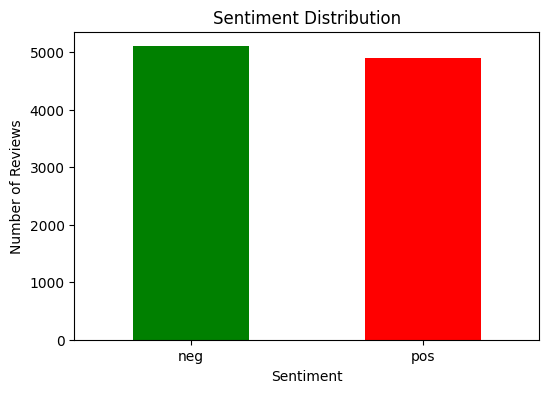

In [31]:
# Sentiment Distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

In [32]:
# Word Clouds for Positive & Negative Reviews
positive_text = " ".join(df[df['label'] == 'pos']['cleaned_review'])
negative_text = " ".join(df[df['label'] == 'neg']['cleaned_review'])

In [33]:
# Creation of Word Clouds
pos_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
neg_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

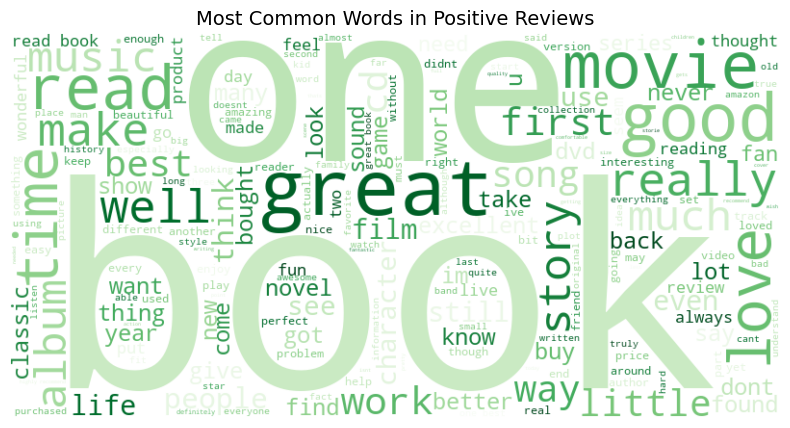

In [34]:
# Display Positive Word Cloud
plt.figure(figsize=(10,5))
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Positive Reviews", fontsize=14)
plt.show()


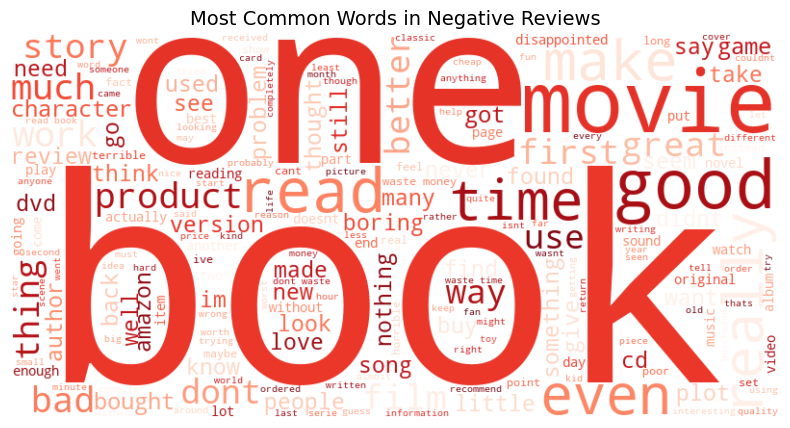

In [35]:
# Display Negative Word Cloud
plt.figure(figsize=(10,5))
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Negative Reviews", fontsize=14)
plt.show()

In [36]:
# Most Common Positive & Negative Words
def get_top_words(texts, n=20):
    all_words = " ".join(texts).split()
    return Counter(all_words).most_common(n)

top_pos_words = get_top_words(df[df['label'] == 'pos']['cleaned_review'])
top_neg_words = get_top_words(df[df['label'] == 'neg']['cleaned_review'])

# Convert to DataFrame for better plotting
pos_df = pd.DataFrame(top_pos_words, columns=['word', 'count'])
neg_df = pd.DataFrame(top_neg_words, columns=['word', 'count'])

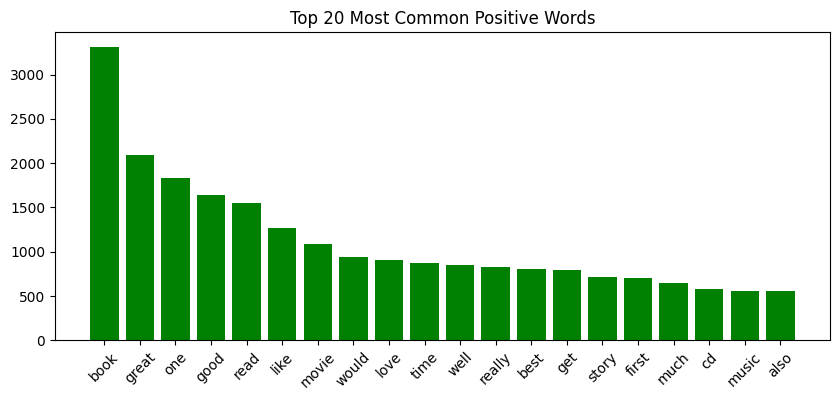

In [37]:
# Plot Top 20 Positive Words
plt.figure(figsize=(10,4))
plt.bar(pos_df['word'], pos_df['count'], color='green')
plt.title('Top 20 Most Common Positive Words')
plt.xticks(rotation=45)
plt.show()

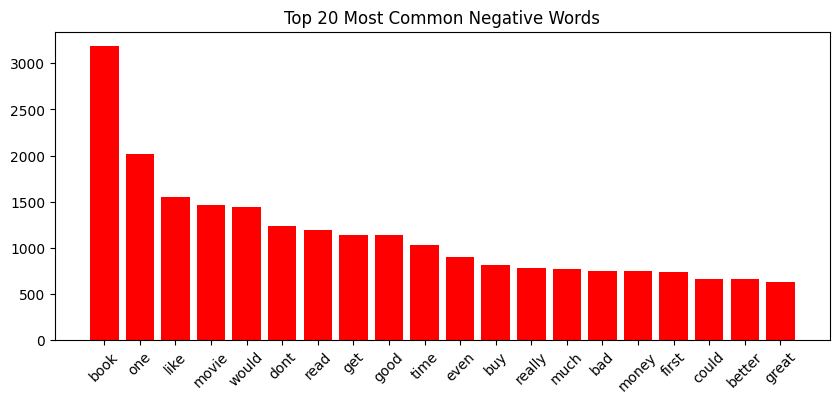

In [38]:
# Plot Top 20 Negative Words
plt.figure(figsize=(10,4))
plt.bar(neg_df['word'], neg_df['count'], color='red')
plt.title('Top 20 Most Common Negative Words')
plt.xticks(rotation=45)
plt.show()

3. Model Development: Use NLP techniques (TF-IDF, Word2Vec, or BERT embeddings) with models like Logistic Regression, SVM, or Neural Networks

In [40]:
# Spliting data into features (X) and labels (y)
X = df['cleaned_review']
y = df['label']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 8000
Testing samples: 2000


In [43]:
# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (8000, 5000)


In [44]:
# Initialize and train Logistic Regression
lr_model = LogisticRegression(max_iter=300)
lr_model.fit(X_train_tfidf, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluation
print("Logistic Regression Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Results:

Accuracy: 0.856

Classification Report:
               precision    recall  f1-score   support

         neg       0.86      0.86      0.86      1019
         pos       0.85      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



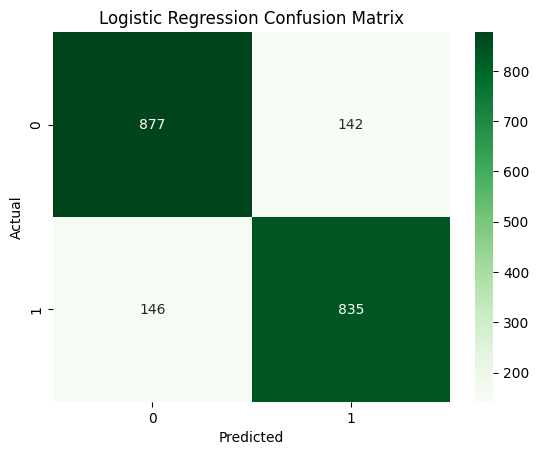

In [45]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [46]:
# Initialize and train Linear SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [47]:
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluation
print("SVM Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


SVM Results:

Accuracy: 0.845

Classification Report:
               precision    recall  f1-score   support

         neg       0.85      0.84      0.85      1019
         pos       0.84      0.85      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.85      0.84      0.85      2000



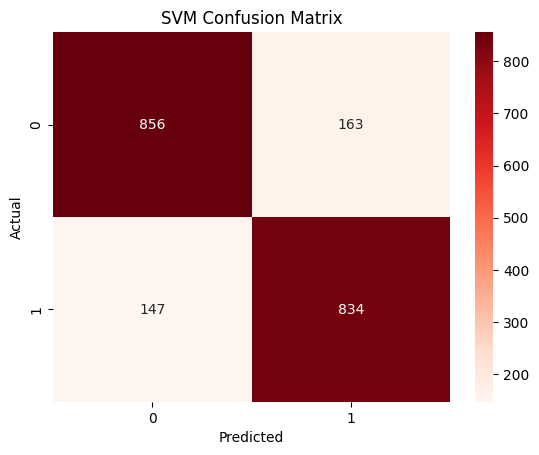

In [48]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

4. Validation: Use train/test split, cross-validation, and metrics like accuracy, F1-score.

In [51]:
# Evaluate Logistic Regression
print("Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, pos_label='pos'))
print("Recall:", recall_score(y_test, y_pred_lr, pos_label='pos'))
print("F1-score:", f1_score(y_test, y_pred_lr, pos_label='pos'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Results
Accuracy: 0.856
Precision: 0.8546571136131014
Recall: 0.8511722731906218
F1-score: 0.8529111338100103

Classification Report:
               precision    recall  f1-score   support

         neg       0.86      0.86      0.86      1019
         pos       0.85      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [54]:
# Cross-validation (5-fold)
cv_scores_lr = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores_lr)
print("Mean CV Accuracy:", cv_scores_lr.mean())

Cross-Validation Accuracy Scores: [0.85875  0.855625 0.865625 0.85875  0.85    ]
Mean CV Accuracy: 0.85775


In [55]:
# Evaluate SVM
print("SVM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, pos_label='pos'))
print("Recall:", recall_score(y_test, y_pred_svm, pos_label='pos'))
print("F1-score:", f1_score(y_test, y_pred_svm, pos_label='pos'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


SVM Results
Accuracy: 0.845
Precision: 0.8365095285857572
Recall: 0.8501529051987767
F1-score: 0.8432760364004045

Classification Report:
               precision    recall  f1-score   support

         neg       0.85      0.84      0.85      1019
         pos       0.84      0.85      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.85      0.84      2000
weighted avg       0.85      0.84      0.85      2000



In [56]:
# Cross-validation for SVM
cv_scores_svm = cross_val_score(svm_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores_svm)
print("Mean CV Accuracy:", cv_scores_svm.mean())

Cross-Validation Accuracy Scores: [0.838125 0.84375  0.863125 0.853125 0.84125 ]
Mean CV Accuracy: 0.8478749999999999


This assignment focuses on sentiment analysis of Amazon customer reviews to classify them as positive or negative. 
                                                           
* The dataset was cleaned by removing duplicates, handling missing values, and preprocessing the text by converting it to lowercase and removing stopwords and punctuation.            

* TF-IDF was applied to convert text data into numerical features suitable for machine learning models.         

* Two models, Logistic Regression and SVM, were used for classification. 

* Logistic Regression achieved an accuracy of 85.6%, while SVM achieved 84.5%.

* Both models performed well, with Logistic Regression showing slightly better and more consistent results.

* The assignment demonstrates how NLP and machine learning techniques can be applied to automatically analyze customer feedback and determine sentiment effectively.

Advanced NLP Techniques                     
🧩 Using Word2Vec Embeddings            
                    
You can use pre-trained Word2Vec (Google News model) to convert each review into averaged word embeddings, then train with SVM or Logistic Regression.

In [ ]:
#pip install gensim

   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   ----- ---------------------------------- 3.4/24.4 MB 25.2 MB/s eta 0:00:01
   ------------- -------------------------- 8.4/24.4 MB 23.7 MB/s eta 0:00:01
   --------------------- ------------------ 13.4/24.4 MB 24.0 MB/s eta 0:00:01
   --------------------------- ------------ 16.8/24.4 MB 22.0 MB/s eta 0:00:01
   -------------------------------- ------- 19.7/24.4 MB 20.4 MB/s eta 0:00:01
   ----------------------------------- ---- 21.8/24.4 MB 18.9 MB/s eta 0:00:01
   ---------------------------------------- 24.4/24.4 MB 18.4 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [59]:
# Example: Using gensim pretrained Word2Vec
from gensim.models import Word2Vec
import numpy as np

# Tokenize reviews
tokenized_reviews = [text.split() for text in X_train]

# Train Word2Vec on your corpus
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=2, workers=4)

# Function to get average vector for each review
def get_vector(text):
    words = text.split()
    word_vecs = [w2v_model.wv[w] for w in words if w in w2v_model.wv]
    return np.mean(word_vecs, axis=0) if len(word_vecs) > 0 else np.zeros(100)

# Create embeddings
X_train_vec = np.vstack([get_vector(text) for text in X_train])
X_test_vec = np.vstack([get_vector(text) for text in X_test])


🤖 Using BERT Embeddings (with Transformers)         
                                                    
For deep contextual embeddings, use BERT (via Hugging Face):

In [1]:
import torch
print(torch.__version__)
print("PyTorch installed correctly:", torch.cuda.is_available())


2.9.0+cpu
PyTorch installed correctly: False


In [2]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

inputs = tokenizer("This product is amazing!", return_tensors='pt', truncation=True, padding=True)
outputs = model(**inputs)

print(outputs.last_hidden_state.shape)


c:\Users\kanch\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\kanch\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kanch\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLI

torch.Size([1, 7, 768])
